## 1. Import Libraries

In [ ]:
!pip install split-folders scikit-learn tensorflow matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import time
import zipfile
import tensorflow as tf
import imutils
import splitfolders
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

### 2. Extract Dataset

In [ ]:
zip_file = "/content/archive.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("Brain Tumor Dataset")

## 3. Exploratory Data Analysis (EDA)

In [ ]:
base_path = "/content/Brain Tumor Dataset/Training"
tumor_types = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

def count_files(base_path):
    for tumor_type in tumor_types:
        folder_path = os.path.join(base_path, tumor_type)
        if os.path.exists(folder_path):
            file_list = os.listdir(folder_path)
            print(f"Number of files in {tumor_type}: {len(file_list)}")
        else:
            print(f"{tumor_type} folder not found!")

print("Brain Tumor MRI Dataset EDA")
count_files(base_path)

Brain Tumor MRI Dataset EDA
Number of files in glioma_tumor: 826
Number of files in meningioma_tumor: 822
Number of files in no_tumor: 395
Number of files in pituitary_tumor: 827


## 4. Augment Data

In [ ]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int(sec_elapsed % (60 * 60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

def augmented_data(base_dir, n_generated_samples, save_base_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    start_time = time.time()

    for tumor_type in tumor_types:
        source_dir = os.path.join(base_dir, tumor_type)
        save_dir = os.path.join(save_base_dir, tumor_type)
        os.makedirs(save_dir, exist_ok=True)

        for filename in os.listdir(source_dir):
            image = cv2.imread(os.path.join(source_dir, filename))
            image = image.reshape((1,) + image.shape)
            save_prefix = 'aug_' + filename[:-4]
            i = 0

            for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_dir, save_prefix=save_prefix, save_format="jpg"):
                i += 1
                if i >= n_generated_samples:
                    break

    end_time = time.time()
    print(f"Data augmentation completed in: {timing(end_time - start_time)}")

base_dir = '/content/Brain Tumor Dataset/Training'
n_generated_samples = 5
save_base_dir = '/content/Augmented Data'
augmented_data(base_dir, n_generated_samples, save_base_dir)


Data augmentation completed in: 0:12:58.406691551208496


## 5. Rename Files

In [ ]:
def rename_files(folder, tumor_name):
    count = 1
    for filename in os.listdir(folder):
        source = os.path.join(folder, filename)
        destination = os.path.join(folder, f"{tumor_name}_{count}.jpg")
        os.rename(source, destination)
        count += 1
    print(f"{tumor_name} Tumor Images Renamed Successfully.")

for tumor in tumor_types:
    folder = f'/content/Augmented Data/{tumor}/'
    rename_files(folder, tumor)

glioma_tumor Tumor Images Renamed Successfully.
meningioma_tumor Tumor Images Renamed Successfully.
no_tumor Tumor Images Renamed Successfully.
pituitary_tumor Tumor Images Renamed Successfully.


## 6. Visualize Dataset

Tumor type counts (Augmented Data): [4129, 4109, 1975, 4132]


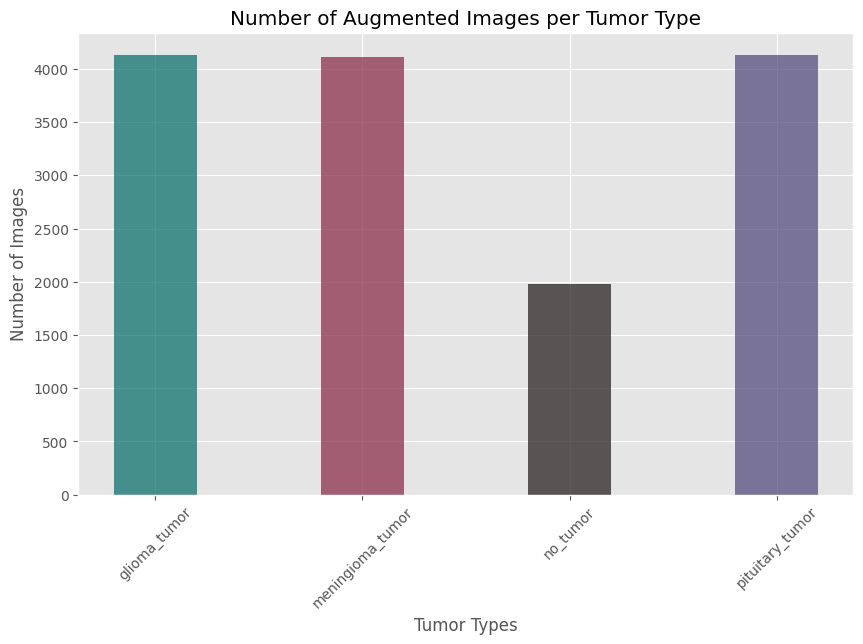

In [ ]:
tumor_counts = [len(os.listdir(os.path.join(save_base_dir, tumor))) for tumor in tumor_types]
print("Tumor type counts (Augmented Data):", tumor_counts)

colors = ['#006A67', '#872341', '#1D1616', '#4B4376']
x = np.arange(len(tumor_types))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x, tumor_counts, width=width, align='center', alpha=0.7, color=colors)
plt.xlabel('Tumor Types')
plt.ylabel('Number of Images')
plt.title('Number of Augmented Images per Tumor Type')
plt.xticks(x, tumor_types, rotation=45)
plt.show()

## 7. Crop Brain Tumor (Remove Black Parts)

In [ ]:
def crop_brain_tumor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return image

    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    cropped_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return cropped_image

def crop_and_save_images(folder_path):
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        if image is not None:
            cropped_image = crop_brain_tumor(image)
            cv2.imwrite(image_path, cropped_image)
            print(f"Processed: {filename}")
        else:
            print(f"Failed to read: {filename}")

for tumor in tumor_types:
    folder_path = os.path.join(save_base_dir, tumor)
    print(f"Processing folder: {folder_path}")
    crop_and_save_images(folder_path)

Streaming output truncated to the last 5000 lines.
Processed: no_tumor_1595.jpg
Processed: no_tumor_1575.jpg
Processed: no_tumor_518.jpg
Processed: no_tumor_351.jpg
Processed: no_tumor_1164.jpg
Processed: no_tumor_1692.jpg
Processed: no_tumor_337.jpg
Processed: no_tumor_494.jpg
Processed: no_tumor_1579.jpg
Processed: no_tumor_1718.jpg
Processed: no_tumor_437.jpg
Processed: no_tumor_1293.jpg
Processed: no_tumor_874.jpg
Processed: no_tumor_215.jpg
Processed: no_tumor_879.jpg
Processed: no_tumor_1571.jpg
Processed: no_tumor_1280.jpg
Processed: no_tumor_639.jpg
Processed: no_tumor_749.jpg
Processed: no_tumor_1555.jpg
Processed: no_tumor_348.jpg
Processed: no_tumor_75.jpg
Processed: no_tumor_1864.jpg
Processed: no_tumor_553.jpg
Processed: no_tumor_1504.jpg
Processed: no_tumor_1179.jpg
Processed: no_tumor_1100.jpg
Processed: no_tumor_590.jpg
Processed: no_tumor_50.jpg
Processed: no_tumor_1627.jpg
Processed: no_tumor_764.jpg
Processed: no_tumor_1308.jpg
Processed: no_tumor_118.jpg
Processed: 

## 8. Split Data

In [ ]:
input_folder = "/content/Augmented Data"
output_folder = "/content/Split Data"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))
print("Dataset successfully split into training, validation, and test sets.")

Copying files: 14345 files [00:08, 1779.43 files/s]

Dataset successfully split into training, validation, and test sets.


In [ ]:
import shutil
from google.colab import files

shutil.make_archive('Split_Data', 'zip', 'Split Data')

files.download('Split_Data.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9. Build CNN Model

In [ ]:
def build_cnn_model():
    model = Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 10. Prepare Data Generators

In [ ]:
train_dir = "/content/Split Data/train"
val_dir = "/content/Split Data/val"
test_dir = "/content/Split Data/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

Found 11480 images belonging to 4 classes.
Found 1434 images belonging to 4 classes.
Found 1436 images belonging to 4 classes.


## 11. Train the Model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3466 - loss: 1.3274

359/359 ━━━━━━━━━━━━━━━━━━━━ 69s 177ms/step - accuracy: 0.3468 - loss: 1.3271 - val_accuracy: 0.5830 - val_loss: 0.9451
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5864 - loss: 0.9636

359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - accuracy: 0.5864 - loss: 0.9635 - val_accuracy: 0.7050 - val_loss: 0.7180
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6481 - loss: 0.8142

359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - accuracy: 0.6481 - loss: 0.8141 - val_accuracy: 0.7824 - val_loss: 0.5738
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7033 - loss: 0.7079

359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.7033 - loss: 0.7079 - val_accuracy: 0.8047 - val_loss: 0.4946
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7377 - loss: 0.6210

359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.7377 - loss: 0.6210 - val_accuracy: 0.8152 - val_loss: 0.4350
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7597 - loss: 0.5913

359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 163ms/step - accuracy: 0.7597 - loss: 0.5913 - val_accuracy: 0.8536 - val_loss: 0.3761
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 161ms/step - accuracy: 0.7894 - loss: 0.5201 - val_accuracy: 0.8389 - val_loss: 0.4005
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8003 - loss: 0.4977

359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - accuracy: 0.8004 - loss: 0.4977 - val_accuracy: 0.8584 - val_loss: 0.3625
Epoch 9/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8161 - loss: 0.4543

359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.8161 - loss: 0.4542 - val_accuracy: 0.9003 - val_loss: 0.2691
Epoch 10/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.8332 - loss: 0.4134 - val_accuracy: 0.8870 - val_loss: 0.3112
Epoch 11/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8458 - loss: 0.3973

359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - accuracy: 0.8458 - loss: 0.3972 - val_accuracy: 0.9045 - val_loss: 0.2504
Epoch 12/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.8530 - loss: 0.3727 - val_accuracy: 0.9086 - val_loss: 0.2620
Epoch 13/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8612 - loss: 0.3519

359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - accuracy: 0.8612 - loss: 0.3519 - val_accuracy: 0.9331 - val_loss: 0.1842
Epoch 14/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - accuracy: 0.8674 - loss: 0.3290 - val_accuracy: 0.8996 - val_loss: 0.2536
Epoch 15/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.8628 - loss: 0.3299 - val_accuracy: 0.9275 - val_loss: 0.1992
Epoch 16/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8680 - loss: 0.3369

359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 163ms/step - accuracy: 0.8680 - loss: 0.3369 - val_accuracy: 0.9456 - val_loss: 0.1463
Epoch 17/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - accuracy: 0.8905 - loss: 0.2882 - val_accuracy: 0.9365 - val_loss: 0.1818
Epoch 18/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 163ms/step - accuracy: 0.8914 - loss: 0.2889 - val_accuracy: 0.9407 - val_loss: 0.1573
Epoch 19/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8884 - loss: 0.2892

359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - accuracy: 0.8884 - loss: 0.2892 - val_accuracy: 0.9589 - val_loss: 0.1415
Epoch 20/20
176/359 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.8997 - loss: 0.2536

## 12. Evaluate on Test Set

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9435 - loss: 0.1365
Test Accuracy: 93.18%


## 13. Accuracy Chart

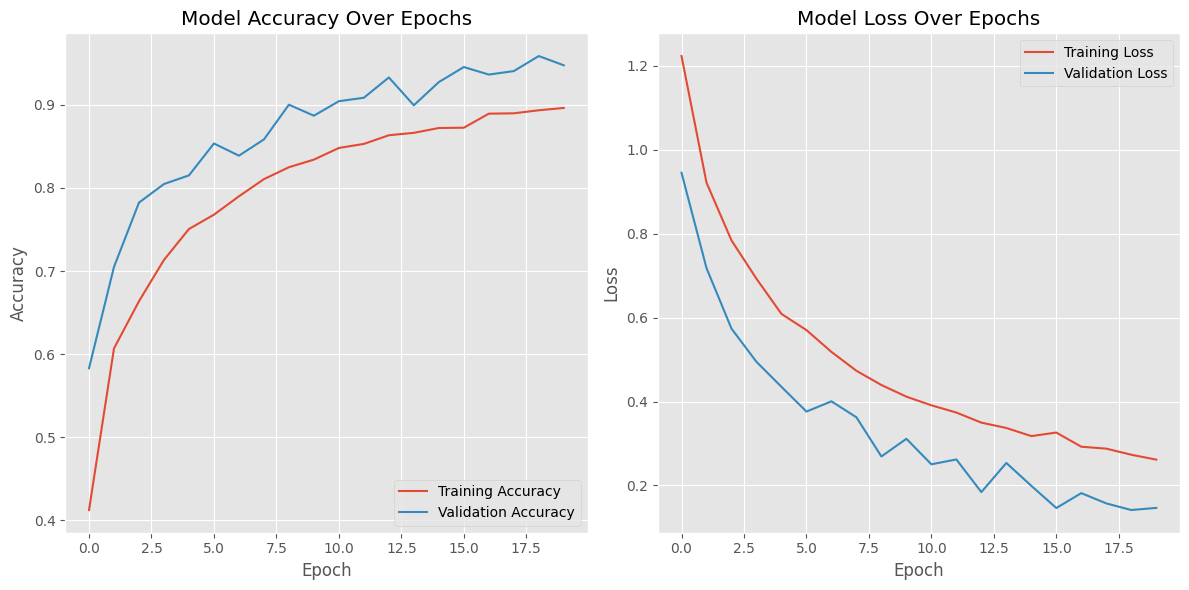

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 14. Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


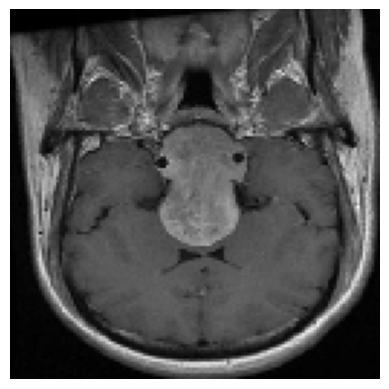

Predicted Tumor Type: pituitary


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/best_model.h5')
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

def predict_image(img_path):
    img, img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Predicted Tumor Type: {class_names[predicted_class[0]]}")

img_path = '/content/Split Data/test/pituitary_tumor/pituitary_tumor_1040.jpg'
predict_image(img_path)
